In [1]:
import numpy as np
import torch, queue
from torch_geometric.data import Data
from utils import gen_edge_index

/home/sam/anaconda3/envs/graphgps/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def parse_config(filename):
    name = filename.split("/")[1]
    modeltype = name.split('-')[1].split('.')[0]
    return modeltype

parse_config('configs/hyperparameter-GCN.yaml')

'GCN'

In [2]:
outputs = [16, 32, 64, 128, 256]
layers = [2]
hidden = [32, 64, 128, 256, 512]

pairs = []
for o in outputs:
    for l in layers:
        for h in hidden:
            pairs.append((o, l, h))
print(pairs)

[(16, 2, 32), (16, 2, 64), (16, 2, 128), (16, 2, 256), (16, 2, 512), (32, 2, 32), (32, 2, 64), (32, 2, 128), (32, 2, 256), (32, 2, 512), (64, 2, 32), (64, 2, 64), (64, 2, 128), (64, 2, 256), (64, 2, 512), (128, 2, 32), (128, 2, 64), (128, 2, 128), (128, 2, 256), (128, 2, 512), (256, 2, 32), (256, 2, 64), (256, 2, 128), (256, 2, 256), (256, 2, 512)]


In [15]:
import yaml 

dictionary = {}
layer_types = ['GCNConv', 'GINLayer', 'GATConv']
input = 3
outputs = [8, 16, 32, 64, 128]
layers = [2, 3, 4]
hidden = [16, 32, 64, 128, 256]

for i in range(len(pairs)):
    phi_output = np.random.choice(outputs).item()
    o, l, h = pairs[i]
    phi = {'input': o, 
           'output': phi_output, 
           'hidden': np.random.choice(hidden).item(), 
           'layers': np.random.choice(layers).item()}
    final = {'input': phi_output,
             'hidden': np.random.choice(hidden).item(),
             'output': 1,
             'layers': np.random.choice(layers).item()}
    gnn = {'layer_type': 'GATConv',
           'input':3, 
           'output': o,
           'hidden': h,
            'layers':l }
    name = f'GAT-{i}'
    dictionary[name] = {'phi': phi, 'final':final, 'gnn':gnn}

file=open("configs/hyperparameter-config-GAT.yaml","w")
result = yaml.dump(dictionary, file)
print("Number of models:", len(dictionary))
file.close()

Number of models: 16


In [6]:
import yaml 

dictionary = {}
layer_types = ['GCNConv', 'GINLayer', 'GATConv']
input = 3
outputs = [8, 16, 32, 64, 128]
layers = [2, 3, 4]
hidden = [16, 32, 64, 128, 256]

for i in range(len(pairs)):
    phi_output = np.random.choice(outputs).item()
    o, l, h = pairs[i]
    mlp = {'input': o, 
           'output': 1, 
           'hidden': o + 32, 
           'layers':2}
    gnn = {'layer_type': 'Transformer',
           'input':3, 
           'output': o,
           'hidden': h,
            'layers':l }
    name = f'Transformer-{i}'
    dictionary[name] = {'mlp': mlp, 'gnn':gnn}

file=open("configs/vary-embedding-Transformer.yaml","w")
result = yaml.dump(dictionary, file)
print("Number of models:", len(dictionary))
file.close()

Number of models: 25


In [3]:
f = open('/data/sam/terrain/norway-smallest.txt')

In [4]:
lines = f.readlines()

In [6]:
arr = []
for i in range(1, len(lines)):
    if i % 1 == 0:
        vals = lines[i].split()
        a = []
        for j in range(len(vals)):
            if j % 1 ==0 :
                a.append(float(vals[j]))
        arr.append(a)
arr = np.array(arr)
print(arr.shape)


(2000, 2000)


In [7]:
sz = arr.shape[0]
resolution = 10
total_width = resolution * sz
x = np.linspace(0, total_width, sz)
y = np.linspace(0, total_width, sz)
xv, yv = np.meshgrid(x, y)


In [8]:
print(xv[0][1])

10.005002501250626


0.8997


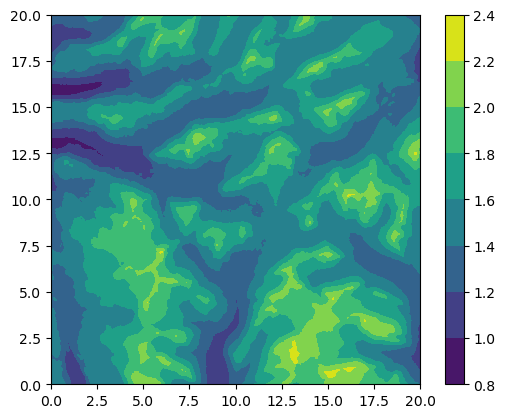

In [9]:
import matplotlib.pyplot as plt

plt.contourf(xv/1000, yv/1000, arr/1000)
print(np.min(arr/1000))
plt.axis("scaled")
plt.colorbar()
plt.show()

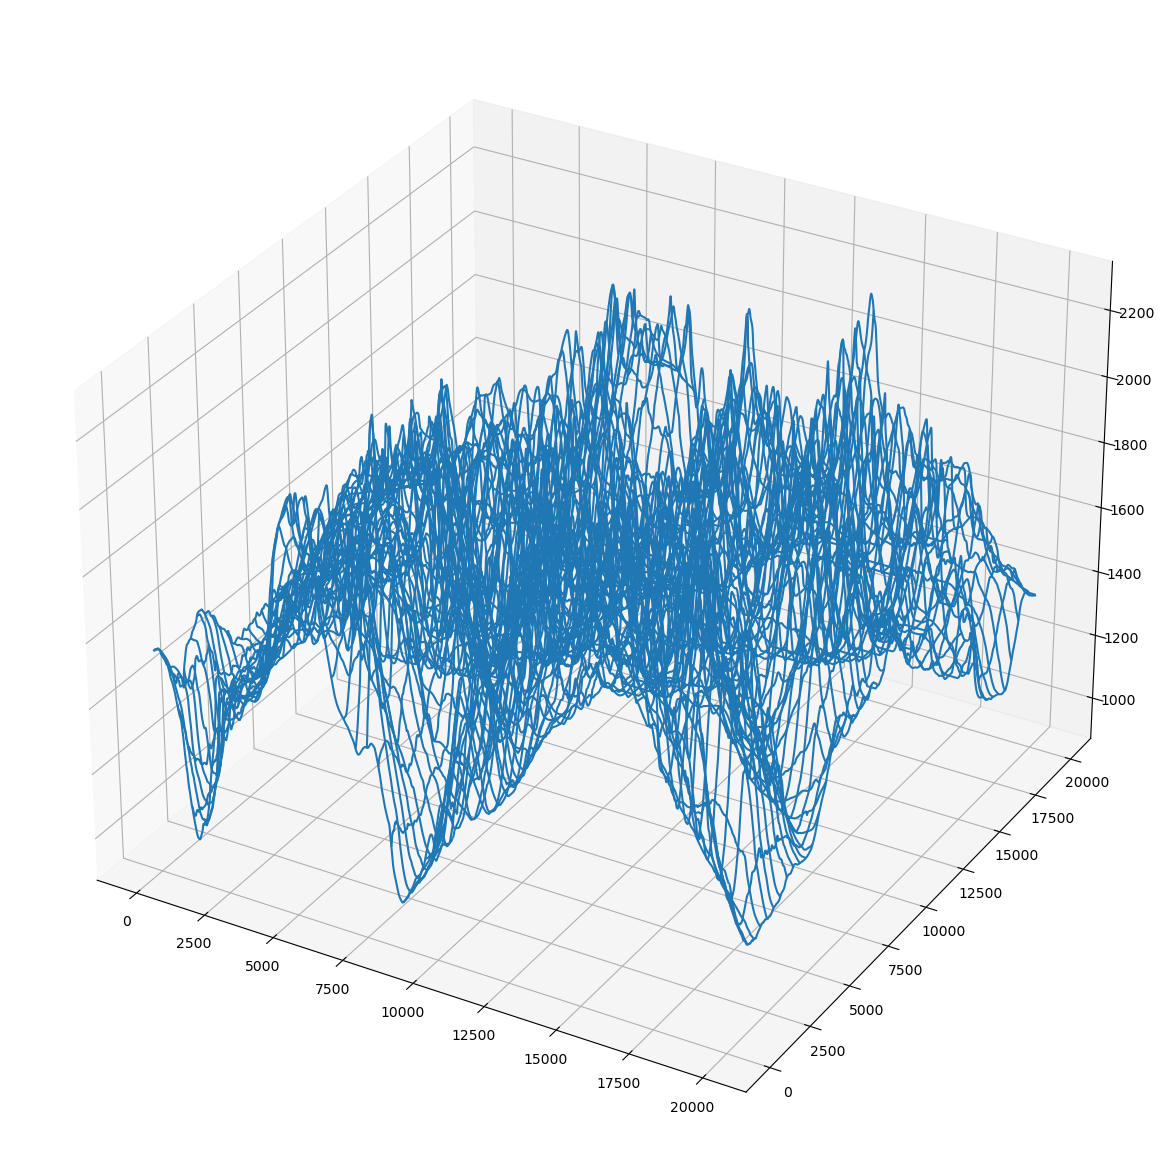

In [10]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(xv, yv, arr)
plt.show()

In [11]:
def get_neighbors(x, y, left=0, right=500, radius=1):
    temp = [(x - radius, y), (x + radius, y), (x, y - radius), (x, y + radius)]
    neighbors = temp.copy()

    for val in temp:
        if val[0] < left or val[0] >= right:
            neighbors.remove(val)
        elif val[1] < left or val[1] >= right:
            neighbors.remove(val)

    return neighbors


100%|██████████| 40/40 [00:05<00:00,  7.19it/s]


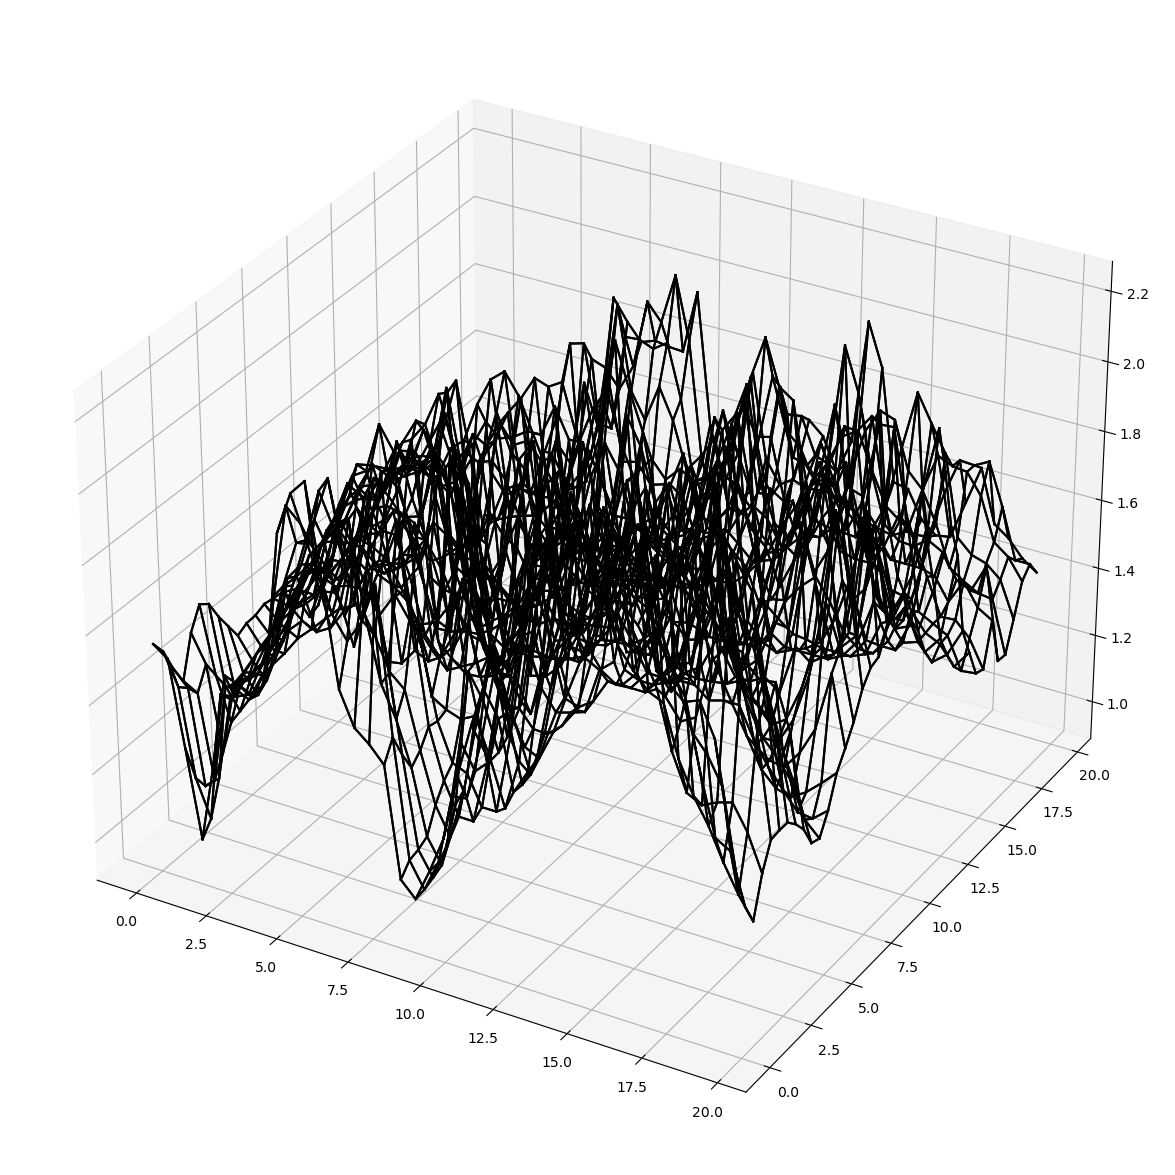

In [12]:
import networkx as nx 
from tqdm import trange

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')
res = 50
sz = 2000//res

counts = np.reshape(np.arange(0, sz*sz), (sz, sz))
G = nx.Graph()
node_features = []

for i in trange(0, len(arr),res):
    for j in range(0, len(arr), res):
        idx1 = counts[i//res, j//res]
        G.add_node(idx1)
        node_features.append(np.array([xv[i, j], yv[i, j], arr[i, j]])/1000)
        neighbors = get_neighbors(i, j, right=arr.shape[0], radius=res)
        for n in neighbors:
            p1 = np.array([xv[i, j], yv[i, j], arr[i, j]])/1000
            p2 = np.array([xv[n[0], n[1]], yv[n[0], n[1]], arr[n[0], n[1]]])/1000
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='black')
            w = np.linalg.norm(p1 - p2)
            idx2 = counts[n[0]//res, n[1]//res]
            G.add_edge(idx1, idx2, weight=w)
            

In [11]:
L = G.edges(data=True)

In [12]:
Nodes = np.sort(list(G.nodes()))
print(len(Nodes))

100


In [19]:
print(Nodes[:10])
print(node_features[:10])


[0 1 2 3 4 5 6 7 8 9]
[array([0.        , 0.        , 0.14724729]), array([0.18258258, 0.        , 0.14789965]), array([0.36516517, 0.        , 0.13828801]), array([0.54774775, 0.        , 0.13834593]), array([0.73033033, 0.        , 0.1446287 ]), array([0.91291291, 0.        , 0.14324473]), array([1.0954955 , 0.        , 0.15553896]), array([1.27807808, 0.        , 0.15467321]), array([1.46066066, 0.        , 0.1566181 ]), array([1.64324324, 0.        , 0.14891781])]


100%|██████████| 180/180 [00:00<00:00, 1270.98it/s]


[0, 10, 0, 1, 10, 20, 10, 11, 1, 11, 1, 2, 11, 21, 11, 12, 2, 12, 2, 3, 12, 22, 12, 13, 3, 13, 3, 4, 13, 23, 13, 14, 4, 14, 4, 5, 14, 24, 14, 15, 5, 15, 5, 6, 15, 25, 15, 16, 6, 16, 6, 7, 16, 26, 16, 17, 7, 17, 7, 8, 17, 27, 17, 18, 8, 18, 8, 9, 18, 28, 18, 19, 9, 19, 19, 29, 20, 30, 20, 21, 21, 31, 21, 22, 22, 32, 22, 23, 23, 33, 23, 24, 24, 34, 24, 25, 25, 35, 25, 26, 26, 36, 26, 27, 27, 37, 27, 28, 28, 38, 28, 29, 29, 39, 30, 40, 30, 31, 31, 41, 31, 32, 32, 42, 32, 33, 33, 43, 33, 34, 34, 44, 34, 35, 35, 45, 35, 36, 36, 46, 36, 37, 37, 47, 37, 38, 38, 48, 38, 39, 39, 49, 40, 50, 40, 41, 41, 51, 41, 42, 42, 52, 42, 43, 43, 53, 43, 44, 44, 54, 44, 45, 45, 55, 45, 46, 46, 56, 46, 47, 47, 57, 47, 48, 48, 58, 48, 49, 49, 59, 50, 60, 50, 51, 51, 61, 51, 52, 52, 62, 52, 53, 53, 63, 53, 54, 54, 64, 54, 55, 55, 65, 55, 56, 56, 66, 56, 57, 57, 67, 57, 58, 58, 68, 58, 59, 59, 69, 60, 70, 60, 61, 61, 71, 61, 62, 62, 72, 62, 63, 63, 73, 63, 64, 64, 74, 64, 65, 65, 75, 65, 66, 66, 76, 66, 67, 67,

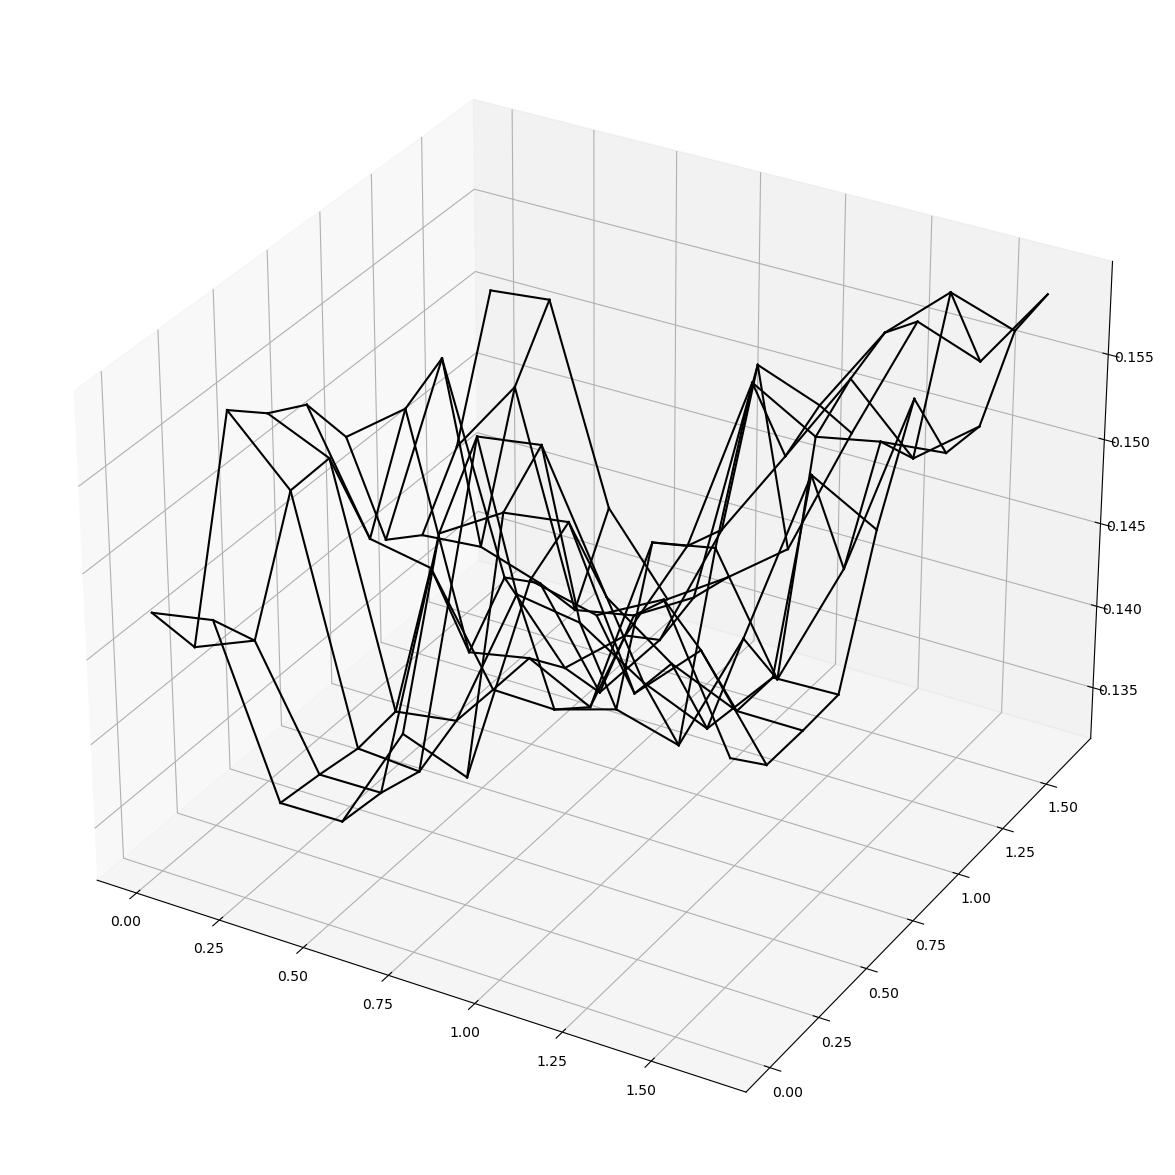

In [13]:
from tqdm import tqdm 

distances = []

edges = [[], []]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

for e in tqdm(G.edges(data=True)):
    edges[0].append(e[0])
    edges[1].append(e[1])
    edges[0].append(e[1])
    edges[1].append(e[0])
    p1 = node_features[e[0]]
    p2= node_features[e[1]]

    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='black')
    distances.append(e[2]['weight'])
    distances.append(e[2]['weight'])
print(edges[0])
print(edges[1])

In [44]:
from torch_geometric.data import Data

data = Data(x=torch.tensor(node_features), edge_index=torch.tensor(edges, dtype=torch.long), num_nodes=len(Nodes))

In [45]:
from typing import Any, Optional

import numpy as np
import torch

from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import (
    get_laplacian,
    to_scipy_sparse_matrix
)
from scipy.sparse.linalg import eigs, eigsh



def add_node_attr(data: Data, value: Any,
                  attr_name: Optional[str] = None) -> Data:
    print(value.size())
    # TODO Move to `BaseTransform`.
    if attr_name is None:
        if 'x' in data:
            x = data.x.view(-1, 1) if data.x.dim() == 1 else data.x
            data.x = torch.cat([x, value.to(x.device, x.dtype)], dim=-1)
        else:
            data.x = value
    else:
        data[attr_name] = value

    return data

def add_laplace_positional_encoding(data, k=10):
    eig_fn = eigsh

    num_nodes = data.num_nodes
    edge_index, edge_weight = get_laplacian(
        data.edge_index,
        data.edge_weight,
        normalization='sym',
        num_nodes=num_nodes,
    )

    L = to_scipy_sparse_matrix(edge_index, edge_weight, num_nodes)

    eig_vals, eig_vecs = eig_fn(
        L,
        k=k + 1,
        which='SA',
        return_eigenvectors=True
    )

    eig_vecs = np.real(eig_vecs[:, eig_vals.argsort()])
    pe = torch.from_numpy(eig_vecs[:, 1:k + 1])
    sign = -1 + 2 * torch.randint(0, 2, (k, ))
    pe *= sign

    data = add_node_attr(data, pe)
    return data


In [46]:
from transforms import AddLaplacianEigenvectorPE
print(data.x.size())
lpe_transform = AddLaplacianEigenvectorPE(k=2)
transformed =add_laplace_positional_encoding(data, k=2)
print(transformed.x.size())


torch.Size([100, 3])
torch.Size([100, 2])
torch.Size([100, 5])


In [32]:
print(vn.edge_index)

tensor([[0, 2, 0, 1, 2, 3, 1, 3, 0, 1, 2, 3, 4, 4, 4, 4],
        [2, 0, 1, 0, 3, 2, 3, 1, 4, 4, 4, 4, 0, 1, 2, 3]])


In [37]:
print(vn.edge_type)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])


In [25]:
import os.path as osp
from torch_geometric.datasets import Planetoid
dataset = 'Cora'
path = '/data/sam/'
transform = T.Compose([T.NormalizeFeatures(), T.GCNNorm(), T.ToSparseTensor()])
dataset = Planetoid(path, dataset, transform=transform)
data = dataset[0]

Processing...
Done!


In [28]:
data.adj_t


None


In [17]:
src, tar = np.random.choice(len(Nodes), [2,], replace=False)
print(src, tar)

71 17


In [18]:
srcs = []
tars = []
lengths = []
paths = []
size = 100
for i in trange(size):
    src, tar = np.random.choice(len(Nodes), [2,], replace=False)
    srcs.append(src)
    tars.append(tar)
    length = nx.shortest_path_length(G, src, tar, weight='weight')
    path_ = nx.shortest_path_length(G, src, tar)
    lengths.append(length)
    paths.append(path_)


100%|██████████| 100/100 [00:00<00:00, 2858.58it/s]


In [19]:

np.savez('/data/sam/terrain/data/holland/holland-100-test.npz', 
         edge_index = edges, 
         distances=distances, 
         nodes=Nodes,
         srcs = srcs,
         tars = tars,
         lengths = lengths,
         node_features=node_features,
         paths=paths)

In [ ]:
srcs = []
tars = []
lengths = []
size = 200
for i in trange(size):
    src, tar = np.random.choice(len(Nodes), [2,], replace=False)
    srcs.append(src)
    tars.append(tar)
    length = nx.shortest_path_length(G, src, tar, weight='weight')
    lengths.append(length)

In [ ]:
np.savez('/data/sam/terrain/data/norway/norway-625-test.npz', 
         edge_index = edges, 
         distances=distances, 
         nodes=Nodes,
         srcs = srcs,
         tars = tars,
         lengths = lengths,
         node_features=node_features)

In [ ]:
def _shortest_path_len(edge_index, edge_distance, src, tar):
    device = edge_index.device
    rol, col = edge_index

    q = queue.PriorityQueue()
    visited_node_set = set()

    # standard Dijkstra's algorithm
    done = False
    q.put((0, torch.tensor(src, device=device)))
    while (not done and not q.empty()):
        length, current_node = q.get()
        if current_node.item() not in visited_node_set:
            visited_node_set.add(current_node.item())
            if tar in current_node:
                done = True
            else:
                mask = rol == current_node
                for node, weight in zip(col[mask].unbind(), edge_distance[mask].unbind()):
                    if node.item() not in visited_node_set:
                        q.put((length+weight, node))
    length = torch.tensor(length.item() if done else -1, dtype=torch.float, device=device).reshape([1])

    return length

def _generate_random_sample(node_num=100, sparsity=0.5, k=8, dim=2, lobster_prob=(0.2,0.2),
                     connect_prob=0.01, index_generator='random', device=None,
                     min_edge_distance=1., max_edge_distance=1., **kwargs):
    edge_index, node_num = gen_edge_index(index_generator, node_num=node_num,
                                          sparsity=sparsity, k=k, dim=dim,
                                          lobster_prob=lobster_prob,
                                          connect_prob=connect_prob,
                                          device=device)
    print(edge_index)
    device = edge_index.device

    edge_distance = torch.rand([edge_index.size(1),1],device=device)*(max_edge_distance-min_edge_distance)+min_edge_distance
    
    src, tar = np.random.choice(node_num, [2,], replace=False)
    node_feat = torch.tensor([[0,0,1] if i != src and i != tar else ([1,0,0] if i == src else [0,1,0]) for i in range(node_num)], dtype=torch.float, device=device)
    length = _shortest_path_len(edge_index, edge_distance, src, tar)
    if max_edge_distance-min_edge_distance > 0.5:
        node_feat = node_feat * (max_edge_distance-min_edge_distance)
    return Data(x=node_feat, edge_index=edge_index, edge_attr=edge_distance, y=length)


In [ ]:
_generate_random_sample(node_num=4, index_generator='lobster')

In [ ]:
import yaml

with open('config.yml', 'r') as file:
    prime_service = yaml.safe_load(file)
print(prime_service)